# Cohort Analysis and Customer Segmentation of E-Commerce Data

The dataset used here is e-commerce data available on [Kaggle](https://www.kaggle.com/carrie1/ecommerce-data/home) and on the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). The data consists of transactions from 2010-2011 of online retail by a UK company. The company sells gifts with the consumers being predominately wholesalers. 


I will be applying the tools and techniques I have learned at DataCamp ([Word Frequency in Moby Dick](https://projects.datacamp.com/projects/38) project and the Karolis Urbonas's [Customer Segmentation in Python](https://www.datacamp.com/courses/customer-segmentation-in-python) course.) The last two sections will feature code presented in the Karolis Urbonas [Customer Segmentation in Python](https://www.datacamp.com/courses/customer-segmentation-in-python)  course.

This notebook is split into 3 sections:
1. Exploratory Data Analysis
2. Cohort Analysis: Retention
3. Customer Segmentation using K-Means

For each section, the insights (english) are at the beginning, followed by the code used to obtain those insights.

Let's take a look at the data!

In [1]:
%matplotlib inline
#import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
#uploads data into dataframe, df, and looks at first 10 entries
df = pd.read_csv('data.csv', encoding = "ISO-8859-1")
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


## Exploratory Data Analysis

We have a 541,909 x 8 dataset. The **8 features** include:
1. Invoice Number
2. Stock Code
3. Description (of item)
4. Quantity (purchased)
5. Invoice Date
6. Unit Price
7. Customer ID
8. Country (of purchase)

There are **missing values** in the Description as well as Customer ID columns. The first code snippet below is what that looks like. After removing these entries with missing values, we have 8 columns with 406,829 entries. There are also duplicated entries (5,268). After removing those, we have 401,604 entries left. 

 **Customers are from** :
1. UK
2. Germany 
3. France
4. Ireland
5. Spain 

(among others) and this dataset contains the activities of **4,372 different customers**. 

**The unit prices of the items sold range from  \\$0 to \\$649.50.** The latter price can be verified with the following code: df[[y.isnumeric() for y in df['StockCode']] & (df.UnitPrice > 300)]. Many of the unit prices higher than \\$649.50 (or in the negative) are for postage or manual adjustments (perhaps due to refunds). The majority of the unit prices are under \\$4. 

The **most popular items** purchased were:
1. White Hanging Heart T-Light Holder
2. Regency Cakestand 3-Tier
3. Jumbo Bag Red Retrospot

To get a sense of what kind of items are being purchased, let's look at the words most frequency used in the description column. (Here, I will only look at the distinct item names in the Description column.)

The **top words** in the description are:
1. set
2. pink
3. heart
4. blue
5. vintage

(All this information can be found by running the code below.)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
#looks at entries with NaN entries
df[pd.isna(df['CustomerID'])].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [5]:
#checks number of rows are duplicates
df.duplicated().sum()

5268

In [6]:
#discards rows that have NaN values or are duplicates
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      401604 non-null object
StockCode      401604 non-null object
Description    401604 non-null object
Quantity       401604 non-null int64
InvoiceDate    401604 non-null object
UnitPrice      401604 non-null float64
CustomerID     401604 non-null float64
Country        401604 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [7]:
#lists customers' countries of origin
df['Country'].value_counts().head()

United Kingdom    356728
Germany             9480
France              8475
EIRE                7475
Spain               2528
Name: Country, dtype: int64

In [8]:
#retrieves number of unique customers
df['CustomerID'].nunique()

4372

In [9]:
#distribution of unit prices on gifts (and not on postage or manual entries)
df[[y.isnumeric() for y in df['StockCode']] & (df.UnitPrice <= 649.50)]['UnitPrice'].describe()

count    366179.000000
mean          2.927796
std           4.558911
min           0.000000
25%           1.250000
50%           1.850000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [10]:
#top 5 purchased gift items
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
Name: Description, dtype: int64

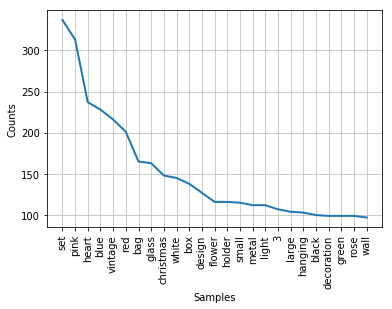

In [11]:
#selects unique description/items, separates into words
gifts = list(set(df.Description))
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
stor =[]

for word in gifts:
    stor.append(str(word).lower())
    
text = ' '.join(stor)
tokens = tokenizer.tokenize(text)
sw = stopwords.words('english')

#stores words that are not stop words
stor_sw = []
for word in tokens:
    if word not in sw:
        stor_sw.append(word)    

#show word frequency plot
freqdist = nltk.FreqDist(stor_sw)
freqdist.plot(25)

## Cohort Analysis: Retention 

Let's move on to analyzing customer activity based on their months of purchases. The dataset is split into cohorts. The cohort month refers to the month of their first purchase. The cohort index of each purchase refers to the months (rounded up) since that customer's first purchase.

The **heatmap** shows the percentage of customers that have continued to purchase from the company. So, for example, let's look at the first cohort month of 12/2010. The group with cohort index 1 has a retention of 100% because December 2010 is the month of their first purchase. The retention of this group in the following month is 38%, meaning 38% of the customers who have made their first purchase in 12/2010 have also made a purchase in 1/2011. 

The **highest retention percentage is 50%**, meaning 50% of customers who made their first purchase in 12/2010 have also made purchases in 12/2011 (It could be because of the holidays).

In [12]:
#convert to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [13]:
#function retrieves year, month, date without the hr/min/sec
def get_day(x): return datetime(x.year, x.month, x.day) 
df['InvoiceDay'] = df['InvoiceDate'].apply(get_day) 

#finds date of first purchase of each customer
grouping = df.groupby('CustomerID')['InvoiceDay'] 
df['CohortDay'] = grouping.transform('min')

In [14]:
#function separates the year, month, date from date column (from Karolis Urbonas's course)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [15]:
#stores year, month, date of invoice and cohort dates
invoice_year, invoice_month, invoice_day = get_date_int(df, 'InvoiceDay')
cohort_year, cohort_month, cohort_day = get_date_int(df, 'CohortDay')

In [16]:
#sets cohort index as months (can be changed to days by changing the last line)
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day
df['CohortIndex'] = years_diff * 12 + months_diff + 1

In [17]:
#change format of date/month (invoice and cohort month to first of the month)
df['InvoiceMonth'] = df['InvoiceDay'].values.astype('datetime64[M]')
df['CohortMonth'] = df['CohortDay'].values.astype('datetime64[M]')
df['CohortMonth'] = df['CohortMonth'].dt.strftime('%Y-%m-%d')

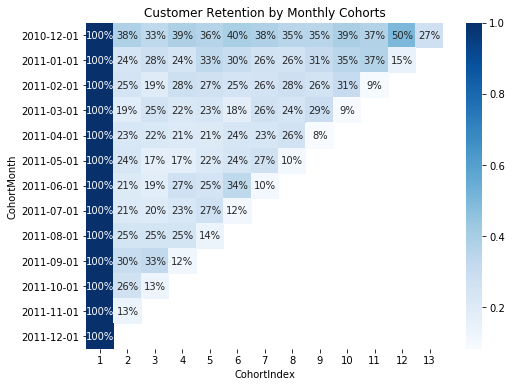

In [26]:
#calculate customer retention by cohort month (by counting number of unique customers per month per index)
cohort_number = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
number_pivot = cohort_number.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
max_size = number_pivot.iloc[:,0]
retention = number_pivot.divide(max_size, axis=0)

plt.figure(figsize=(8, 6))
plt.title('Customer Retention by Monthly Cohorts')
sns.heatmap(retention, annot=True, fmt = '.0%',cmap='Blues')
plt.show()

## Customer Segmentation using K-Means

K-means is a clustering algorithm that identifies which rows of data belong to which of the k-clusters. In other words, the algorithm groups the data into k clusters, in which k is specified by the user. The **elbow method** can be used to find the appropriate k.

To analyze the above customer data some more, we look at:
1. Recency: number of days since most recent purchase 
2. Frequency: number of purchases
3. Monetary Value: total cost of purchases (quantity * unit price)

This can be found below in the data frame, main, which we obtained by extracting relevant information from the data frame, df.

There are 55 customers who have MonetaryValue that is less than or equal to 0. (Note: I put <= 1 because of values on the magnitude of 10e-14.)  The 0 is most likely due to purchasing and then returning. The negative values could refer to damaged/missing items that had to be refunded or they can refer to cancelled purchases. They could also be a result of working with a dataset that's only a snapshot of activity from 12/2010 to 12/2011. For this current exercise of customer segmentation, I will be focusing on **customers with positive Monetary Values.**

First, we prep the dataset for the k-means algorithm. This means taking the logarithm of recency, frequency, and monetary values columns and then normalizing (center and scale). Using the elbow method, k values of at least 3 or 4 seem appropriate.

After running the k-means algorithm on the data with a **k = 4**, each customer (i.e. each row of the data frame, main) is assign to a cluster. **Averaging the recency, frequency, and monetary values by cluster**, we obtain our final table.

Customers in:
1. Cluster 0 - purchased recently, with some average frequency, with moderate average spending
2. Cluster 1 - have not purchased recently, who purchase rarely, with the least average spending
3. Cluster 2 - purchased somewhat recently, at moderate frequency, with the second highest average spending
4. Cluster 3 - purchased recently, with the highest average frequency, with the highest average spending

These kinds of analysis are handy in identifying the kinds of consumer behavior a particular customer exhibits. They can then give insights into which customers would respond favorably to marketing campaigns, for example.

In [19]:
#creates the total amount of purchase
df['Total'] = df['UnitPrice']*df['Quantity']
#sets the current date for recency calculation
r_date = pd.Timestamp(2011,12,10,13)

In [20]:
#calculates recency, freqency and monetary value from df data frame
main = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (r_date - x.max()).days,
    'InvoiceNo': 'count',
    'Total': 'sum'})

main.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Total': 'MonetaryValue'}, inplace=True)

In [21]:
#calculates how many customers have total = 0 (<=1 for entries like 10e-14)
sum(main.MonetaryValue <= 1)

55

In [22]:
#new data frame to look at customers with only positive totals
newmain = main[main.MonetaryValue > 1]

#log the columns
newmain_log = np.log(newmain)

#center and scale columns
scaler = StandardScaler(); scaler.fit(newmain_log)

newmain_normalized = scaler.transform(newmain_log)

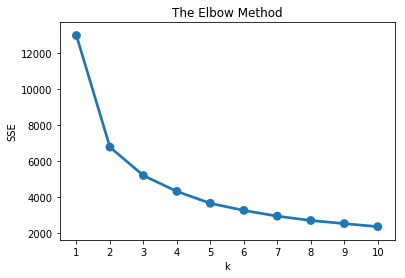

In [23]:
#elbow method by running through possible k values and recording sse (sum of squares distances)
sse = {}
for k in range(1, 11):
    
    kmeans = KMeans(n_clusters=k, random_state=1).fit(newmain_normalized)

    sse[k] = kmeans.inertia_  

plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [24]:
#k-means clustering algorithm with k=4
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(newmain_normalized)
cluster_labels = kmeans.labels_

In [25]:
#assigns cluster number to customer
newmain_clusters = newmain.assign(Cluster=cluster_labels)

#find average recency, frequency, monetary values for each cluster
newmain_clusters.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
  }).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,17.67,39.95,605.23
1,180.25,15.35,282.06
2,91.96,81.29,1354.59
3,11.65,287.93,6713.74
